In [1]:
from sklearn import tree
from sklearn import svm
from hyperopt import hp, fmin, tpe
import imutils
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
import os
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
from tensorflow.python.framework.config import set_memory_growth
tf.compat.v1.disable_v2_behavior()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def preprocess_data(output_img_sz, ar=False):
    '''
    Function to preprocess training images

            Parameters:
                    output_img_sz (int): The width of the output image
                    ar (int): 1 for maintaining aspect ratio and 0 for square image
            Returns:
                    Normalised and resized images and labels
     '''
    train_labels = pd.read_csv(
        'C:/Users/Thomas/OneDrive/Desktop/UON/mlis2/project/training_norm.csv')
    train_labels.head()
    train_labels = train_labels.to_numpy()
    images = []
    train_labels[train_labels[:, 1] > 1, 2] = 1

    

    for x in train_labels[:, 0]:
        imag_arr = Image.open(
            'C:/Users/Thomas/OneDrive/Desktop/UON/mlis2/project/training_data/' + str(int(x))+'.png').convert('RGB')
        if ar == False:
            imag_arr = np.array(imag_arr.resize(
                (output_img_sz, output_img_sz)))/255
        else:
            
            imag_arr = imutils.resize(
                np.array(imag_arr), width=output_img_sz)/255

        images.append(imag_arr)
    images = np.array(images)  
    
    train_labels = train_labels[:, 1:]
    return images, train_labels


In [4]:
def additional_data(output_img_sz, dir, ar=False):
    '''
    Function to preprocess self collected images

            Parameters:
                    output_img_sz (int): The width of the output image
                    ar (int): 1 for maintaining aspect ratio and 0 for square image
                    dir (str): Directory of self collected images
            Returns:
                    Normalised and resized images and labels
    '''
    labels = []
    images = []
    
    for text in os.listdir(dir):
        imag_arr = Image.open(dir+'/'+text).convert('RGB')
        if ar == False:
            imag_arr = np.array(imag_arr.resize(
                (output_img_sz, output_img_sz)))/255
        else:
            imag_arr = imutils.resize(
                np.array(imag_arr), width=output_img_sz)/255
        images.append(imag_arr)
        split = text.split('_')
        label1 = split[1]
        label2 = split[2].split('.')[0]
        labels.append([label1, label2])
    images = np.array(images)
    labels = np.array(labels, dtype=float)  
    print(images.shape)
    labels[:, 0] = (labels[:, 0]-50)/80
    labels[:, 1] = labels[:, 1]/35

    return images, labels


In [4]:
def shuffle(images, train_labels):
    '''
    Function to shuffle images and labels

            Parameters:
                    images (array): The width of the output image
                    train_labels (array): 1 for maintaining aspect ratio and 0 for square image
            Returns:
                    shuffled images and labels
    '''
    index = np.random.permutation(images.shape[0])
    images = images[index, :, :, :]
    train_labels = train_labels[index, :]
    return images, train_labels


In [5]:
def train_test_split(train_split, images, train_labels):
    '''
    Function to split images into testing and training groups

            Parameters:
                    train_split (float): The training split
                    images (array): The images
                    train_labels (array): The image labels
            Returns:
                    training and testing images and labels
    '''
    idx = int(len(images)*train_split)
    train = images[:idx, :, :, :]
    val = images[idx:, :, :, :]
    val_labels = train_labels[idx:, :]
    train_labels = train_labels[:idx, :]
    return train, train_labels, val, val_labels


In [5]:
def create_CNN():
    '''
    Function to create CNN
            Returns:
                    CNN
    '''
    model = tf.keras.models.Sequential([
        Conv2D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        Conv2D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        Conv2D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        Dense(300, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        Dense(160, activation='relu'),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [6]:
def create_adjustable_CNN(f1, f2, f3, k1, k2, k3):
    '''
    Function to create adjustable CNN

            Parameters:
                   f1-f3 (int): The number of filters in layers 1-3
                    k1-k3 (int): The kernel size for layers 1-3
            Returns:
                    Custom CNN
    '''
    model = tf.keras.models.Sequential([
        Conv2D(filters=f1, kernel_size=k1, activation='relu', padding='same'),
        MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        Conv2D(filters=f2, kernel_size=k2, activation='relu', padding='same'),
        MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        Conv2D(filters=f3, kernel_size=k3, activation='relu', padding='same'),
        MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        Dense(300, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        Dense(160, activation='relu'),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
class customcb(tf.keras.callbacks.Callback):
    '''
    Class to save best model when running a model multiple times

    '''

    def __init__(self, best_loss, dir):
        super(customcb, self).__init__()
        self.best_loss = best_loss
        self.dir = dir

    def on_epoch_end(self, epoch, logs=None):
        if logs['val_loss'] < self.best_loss:
            self.best_loss = logs['val_loss']
            self.model.save(self.dir)


# CNN

## Hyperparamer tuning

In [9]:
def objective(args):
    '''
    Function to produce minimisation objective for hyperparameter tuning

            Parameters:
                    args (list): The value of ar, image size, f1-f3 and k1-k3
            Returns:
                    The minimum validation loss of a single CNN
    '''

    ar, img_sz, f1, f2, f3, k1, k2, k3 = args
    ar, img_sz, f1, f2, f3, k1, k2, k3 = ar[1], int(
        img_sz[1]), f1[1], f2[1], f3[1], k1[1], k2[1], k3[1]
    
    images, labels = preprocess_data(img_sz, ar)
    model = create_adjustable_CNN(int(f1), int(
        f2), int(f3), int(k1), int(k2), int(k3))
    train, train_labels, val, val_labels = train_test_split(
        0.8, images, labels)
    history = model.fit(train, train_labels, validation_data=(
        val, val_labels), batch_size=100, epochs=200, verbose=0)
    tf.keras.backend.clear_session()
    return np.min(history.history['val_loss'])


In [10]:
space = [('ar_choice', hp.choice('ar', [0, 1])), ('image_size', hp.quniform('img_sz', 30, 120, 1)), ('filters1', hp.quniform('f1', 30, 80, 1)), ('filters2', hp.quniform(
    'f2', 30, 80, 1)), ('filters3', hp.quniform('f3', 30, 80, 1)), ('kernel1', hp.quniform('k1', 3, 7, 1)), ('kernel2', hp.quniform('k2', 3, 7, 1)), ('kernel3', hp.quniform('k3', 3, 7, 1))]


In [ ]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)


In [12]:
print(best)


{'ar': 0, 'f1': 66.0, 'f2': 80.0, 'f3': 63.0, 'img_sz': 120.0, 'k1': 3.0, 'k2': 7.0, 'k3': 6.0}


## Using Optimal Hyperparameters

In [24]:
def objective_save_model(args, callback):
    '''
    Function to use optimal hyperparmeters and save model

            Parameters:
                    args (list): The value of ar, image size, f1-f3 and k1-k3
            Returns:
                    Normalised and resized images and labels
    '''

    ar, img_sz, f1, f2, f3, k1, k2, k3 = args
    ar, img_sz, f1, f2, f3, k1, k2, k3 = ar[1], int(
        img_sz[1]), f1[1], f2[1], f3[1], k1[1], k2[1], k3[1]
    
    images, labels = preprocess_data(img_sz, ar)
    model = create_adjustable_CNN(int(f1), int(
        f2), int(f3), int(k1), int(k2), int(k3))
    train, train_labels, val, val_labels = train_test_split(
        0.8, images, labels)
    history = model.fit(train, train_labels, validation_data=(
        val, val_labels), batch_size=100, epochs=300, verbose=0, callbacks=[callback])
    tf.keras.backend.clear_session()
    return np.min(history.history['val_loss'])


In [ ]:
#{'ar': 0, 'f1': 66.0, 'f2': 80.0, 'f3': 63.0, 'img_sz': 120.0, 'k1': 3.0, 'k2': 7.0, 'k3': 6.0}
dir = 'C:/Users/Thomas/OneDrive/Desktop/UON/mlis2/project/Optimized_models/cnn.h5'
losses = np.ones([1, 10])
args = [('ar', 0), ('img_sz', 120.0), ('f1', 66.0), ('f2', 80.0),
        ('f3', 63.0), ('k1', 3.0), ('k2', 7.0), ('k3', 6.0)]
for i in range(10):
    loss = objective_save_model(args, customcb(
        best_loss=np.min(losses), dir=dir))
    losses[0, i] = loss
    


In [26]:
cnn_mean_loss = np.mean(losses)
cnn_var_loss = np.var(losses)
print(cnn_mean_loss, cnn_var_loss)


0.008806848635865564 2.863938018865861e-07


# Autoencoder

In [56]:
def create_encoder(img_sz, train, val):
    '''
    Function to produce encoder model

            Parameters:
                    img_sz (list): The image size
                    train (array): The train images
                    val (array): The validation images
            Returns:
                    The encoder model
    '''
    tf.keras.backend.clear_session()
    input = tf.keras.layers.Input(shape=[img_sz[0], img_sz[1], 3])
    x = tf.keras.layers.Conv2D(40, 3, 2, activation='relu')(input)
    x = tf.keras.layers.Conv2D(80, 3, 2, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    units = x.shape[1]
    encoded = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.Dense(5200)(encoded)
    x = tf.keras.layers.Reshape(target_shape=(20, 20, 13))(x)
    x = tf.keras.layers.Conv2DTranspose(
        80, 3, 2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(
        40, 3, 2, padding='same', activation='relu')(x)
    decoded = tf.keras.layers.Conv2DTranspose(3, 3, 1, padding='same')(x)
    auto_encoder = tf.keras.models.Model(inputs=[input], outputs=[decoded])
    auto_encoder.compile(optimizer='adam', loss='mse')

    auto_encoder.fit(train, train, batch_size=120, epochs=50,
                     validation_data=(val, val), verbose=0)
    
    encoder = tf.keras.models.Model(inputs=[input], outputs=[encoded])
    encoder.save('encoder.h5')
    return encoder


In [15]:
images, labels = preprocess_data(80, 0)
train, train_labels, val, val_labels = train_test_split(0.8, images, labels)


In [ ]:
create_encoder([80, 80], train, val)


## SVM

In [52]:
def SVM_loss(encoder, train, train_labels, val, val_labels, k1, C1, epsilon1, d1, k2, C2, epsilon2, d2):
    '''
    Function to fit SVM and return validation loss

            Parameters:
                    encoder (tf model): The encoder model
                    train (array): The training data
                    train_labels (array): The training labels
                    val (array): The validation data
                    val_labels (array): The validation labels
                    k1,k2 (str): The SVM kernel
                    C1,C2 (float): The SVM box constraint
                    epsilon1,epsilon2 (float): The SVM epislon value
                    d1,d2 (int): The polynomial kernel degree
            Returns:
                    The SVM validation loss
    '''
    encoded_train = np.zeros([len(train), 100])

    dx = int(len(train)/10)
    for x in range(10):
        end_indx = np.min([dx*(x+1), len(train)])

        encoded_train[dx*x:end_indx,
                      :] = encoder.predict(train[dx*x:end_indx, :, :, :])

    regress = svm.SVR(kernel=k1, C=C1, epsilon=epsilon1, degree=d1)
    regress.fit(encoded_train, train_labels[:, 0])
    classif = svm.SVR(kernel=k2, C=C2, epsilon=epsilon2, degree=d2)
    classif.fit(encoded_train, train_labels[:, 1])

    encoded_val = encoder.predict(val)
    regress_preds = regress.predict(encoded_val)
    classif_preds = classif.predict(encoded_val)
    loss = (np.square(classif_preds-val_labels[:, 1]).mean())+(
        np.square(regress_preds-val_labels[:, 0])).mean()
    return loss


In [53]:
def objective(args):
    '''
     Objective to minimise for SVM hyperparameter tuning

             Parameters:
                     args (list): k1,k2,C1,C2,epsilon1,epsilon2,d1,d2
             Returns:
                     The SVM validation loss
     '''
    k1, k2, C1, C2, epsilon1, epsilon2, d1, d2 = args
    
    k1, C1, epsilon1, d1, k2, C2, epsilon2, d2 = k1[1], C1[1], epsilon1[1], int(
        d1[1]), k2[1], C2[1], epsilon2[1], int(d2[1])
    images, labels = preprocess_data(80, 0)
    train, train_labels, val, val_labels = train_test_split(
        0.8, images, labels)

    encoder = tf.keras.models.load_model('encoder.h5')
    return SVM_loss(encoder, train, train_labels, val, val_labels, k1, C1, epsilon1, d1, k2, C2, epsilon2, d2)


In [12]:
space = [('kernel1', hp.choice('k1', ['rbf', 'poly'])), ('kernel2', hp.choice('k2', ['rbf', 'poly'])), ('Con1', hp.quniform('C1', 1, 300, 1)), ('Con2', hp.uniform(
    'C2', 1, 300)), ('epsilon1', hp.uniform('e1', 0.08, 1)), ('epsilon2', hp.uniform('e2', 0.08, 1)), ('d1', hp.quniform('d1', 2, 5, 1)), ('d2', hp.quniform('d2', 2, 5, 1))]


In [ ]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)


In [14]:
print(best)

{'C1': 38.0, 'C2': 87.71277285648118, 'd1': 2.0, 'd2': 3.0, 'e1': 0.08056123968432027, 'e2': 0.08033113935585406, 'k1': 0, 'k2': 0}


### Using best hyperparameters

In [50]:
images, labels = preprocess_data(80, 0)
train, train_labels, val, val_labels = train_test_split(0.8, images, labels)


In [ ]:

args = [('k1', 'rbf'), ('k2', 'rbf'), ('C1', 38.0), ('C2', 87.71277285648118),
        ('e1', 0.08056123968432027), ('e2', 0.08033113935585406), ('d1', 2.0), ('d2', 3.0)]
losses = []
for i in range(10):
    create_encoder([80, 80], train, val)
    loss = objective(args)
    losses.append(loss)


In [60]:
svm_mean_loss = np.mean(losses)
svm_var_loss = np.var(losses)
print(svm_mean_loss)
print(svm_var_loss)


0.040636647260010705
4.665078189045113e-07


## Decision Tree

In [ ]:
def DT_loss(train, train_labels, val, val_labels, encoder, md1, md2, msl1, msl2):
    '''
    Function to produce decision tree loss

            Parameters:
                    encoder (tf model): The encoder model
                    train (array): The training data
                    train_labels (array): The training labels
                    val (array): The validation data
                    val_labels (array): The validation labels
                    encoder (model): Encoder model
                    md1,md2 (int): Max depth for each model
                    msl1,msl2 (int): Minimum number of samples in leaf node for each model
            Returns:
                    The decision tree loss
    '''
    encoded_train = np.zeros([len(train), 100])
    dx = int(len(train)/10)
    for x in range(10):
        end_indx = np.min([dx*(x+1), len(train)])

        encoded_train[dx*x:end_indx,
                      :] = encoder(train[dx*x:end_indx, :, :, :])
    encoded_val = encoder(val)
    clf1 = tree.DecisionTreeRegressor(max_depth=md1, min_samples_leaf=msl1)
    clf2 = tree.DecisionTreeRegressor(max_depth=md2, min_samples_leaf=msl2)
    clf1 = clf1.fit(encoded_train, train_labels[:, 0])
    clf2 = clf2.fit(encoded_train, train_labels[:, 1])
    predictions1 = clf1.predict(encoded_val)
    predictions2 = clf2.predict(encoded_val)
    loss1 = tf.keras.losses.MSE(predictions1, val_labels[:, 0])
    loss2 = tf.keras.losses.MSE(predictions2, val_labels[:, 1])
    return loss1+loss2


In [ ]:
def objective(args):
     '''
    Objective to minimise for DT hyperparameter tuning

            Parameters:
                    args (list): ar,img_sz,md1,md2,msl1,msl2
            Returns:
                    The DT validation loss
    '''
    ar,img_sz,md1,md2,msl1,msl2=args
    img_sz,ar,md1,md2,msl1,msl2=int(img_sz[1]),ar[1],int(md1[1]),int(md2[1]),int(msl1[1]),int(msl2[1])
    images,labels=preprocess_data(img_sz,ar)
    train,train_labels,val,val_labels=train_test_split(0.8,images,labels)
    encoder=create_encoder(images.shape[1:3],train,val)
    return DT_loss(train,train_labels,val,val_labels,encoder,md1,md2,msl1,msl2)
    

In [ ]:
space = [('ar_choice', hp.choice('ar', [0, 1])), ('image_size', hp.quniform('img_sz', 30, 200, 1)), ('max_depth1', hp.quniform('md1', 30, 300, 1)),
         ('max_depth2', hp.quniform('md2', 30, 300, 1)), ('min_samples1', hp.quniform('msl1', 1, 300, 1)), ('min_samples2', hp.quniform('msl2', 1, 300, 1))]


In [ ]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

## Decision Head

In [42]:
def DH_loss(encoder, train, train_labels, val, val_labels, d1, d2):
     '''
    Function to find loss of autoencoder with decision head model

            Parameters:
                    encoder (tf model): encoder model
                    train (array): The training data
                    train_labels (array): The training labels
                    val (array): The validation data
                    val_labels (array): The validation labels
                    d1,d2 (int): Number of dense units in layers 1 and 2

            Returns:
                    The DH validation loss
    '''
    x=tf.keras.layers.Dense(d1,activation='relu',name='l')(encoder.output)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(d2,activation='relu',name='ll')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    output=tf.keras.layers.Dense(2,name='lll')(x)
    encoder.trainable=False
    final_model=tf.keras.models.Model(inputs=[encoder.input],outputs=[output])
    final_model.compile(optimizer='adam',loss='mse')
    history=final_model.fit(train,train_labels,validation_data=(val,val_labels),epochs=200,batch_size=120,verbose=0)
    tf.keras.backend.clear_session()
    return np.min(history.history['val_loss'])


In [43]:
def objective(args):
    '''
    Objective to minimise for DH hyperparameter tune

            Parameters:
                    args (list): d1 and d2

            Returns:
                    The DH validation loss
    '''
    tf.keras.backend.clear_session()
    d1, d2 = args
    d1, d2 = int(d1[1]), int(d2[1])
    images, labels = preprocess_data(80, 0)
    train, train_labels, val, val_labels = train_test_split(
        0.8, images, labels)
    encoder = tf.keras.models.load_model('encoder.h5')
    return DH_loss(encoder, train, train_labels, val, val_labels, d1, d2)


In [44]:
space = [('dense1', hp.quniform('d1', 30, 500, 1)),
         ('dense2', hp.quniform('d2', 5, 80, 1))]


In [ ]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)


In [26]:
print(best)

{'d1': 431.0, 'd2': 76.0}


### Use best hyperparameterss

In [ ]:

args = [('d1', 431.0), ('d2', 76.0)]
losses = []
for i in range(10):
    loss = objective(args)
    losses.append(loss)


In [48]:
dh_mean_loss = np.mean(losses)
dh_var_loss = np.var(losses)
print(dh_mean_loss)
print(dh_var_loss)


0.01641359026197799
2.9602659501909622e-08


# Ensemble methods

## Hyperparameter tuning

In [15]:
def ensemble(k, images, labels):
    '''
    Function to find loss of CNN ensemble

            Parameters:
                    k (int): Number of models
                    images (array): The images
                    labels (array): The labels

            Returns:
                    The mean ensemble validation loss
    '''
    losses = []

    for i in range(k):
        tf.keras.backend.clear_session()
        top_index = (i+1)*int(np.ceil(len(images)/k))
        bottom_index = i*int(np.ceil(len(images)/k))
        val = images[bottom_index:top_index, :, :, :]
        val_labels = labels[bottom_index:top_index, :]
        train1 = images[:bottom_index, :, :, :]
        train2 = images[top_index:, :, :, :]

        train = np.concatenate([train1, train2], axis=0)
        train_labels1 = labels[:bottom_index, :]
        train_labels2 = labels[top_index:, :]
        train_labels = np.concatenate([train_labels1, train_labels2], axis=0)
        model = create_CNN()
        history = model.fit(train, train_labels, validation_data=(
            val, val_labels), batch_size=200, epochs=200, verbose=0)
        losses.append(np.min(history.history['val_loss']))
    return np.mean(np.array(losses))


In [16]:
def objective(args):
    '''
    Objective for ensmeble for hyperparameter tuning
            Parameters:
                    args (list): ar,img_sz,

            Returns:
                    The mean ensemble validation loss
    '''

    ar, img_sz, k = args
    ar = ar[1]
    img_sz = int(img_sz[1])
    k = int(k[1])
    
    images, labels = preprocess_data(img_sz, ar)
    return ensemble(k, images, labels)


In [17]:
space = [('ar_choice', hp.choice('ar', [0, 1])), ('image_size', hp.quniform(
    'img_sz', 30, 120, 1)), ('number_mods', hp.quniform('k', 3, 15, 1))]


In [ ]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=30)

In [19]:
print(best)

{'ar': 0, 'img_sz': 70.0, 'k': 14.0}


## Using best hyperparameters

In [35]:
def ensemble(k, images, labels, loss_hist):
    '''
    Function to find losses of ensemble and save best model given loss history

            Parameters:
                    k (int): Number of models
                    images (array): The images
                    labels (array): The labels
                    loss_hist (array): The previous models best losses

            Returns:
                    The ensemble validation losses
    '''
    losses = []
    dir = 'C:/Users/Thomas/OneDrive/Desktop/UON/mlis2/project/Optimized_models/ensemble_'
    for i in range(k):
        tf.keras.backend.clear_session()
        top_index = (i+1)*int(np.ceil(len(images)/k))
        bottom_index = i*int(np.ceil(len(images)/k))
        val = images[bottom_index:top_index, :, :, :]
        val_labels = labels[bottom_index:top_index, :]
        train1 = images[:bottom_index, :, :, :]
        train2 = images[top_index:, :, :, :]

        train = np.concatenate([train1, train2], axis=0)
        train_labels1 = labels[:bottom_index, :]
        train_labels2 = labels[top_index:, :]
        train_labels = np.concatenate([train_labels1, train_labels2], axis=0)
        model = create_CNN()
        best_loss = loss_hist[i]
        history = model.fit(train, train_labels, validation_data=(val, val_labels), batch_size=200,
                            epochs=200, verbose=0, callbacks=[customcb(best_loss=best_loss, dir=dir+str(i)+'.h5')])
        losses.append(np.min(history.history['val_loss']))
    return np.array(losses)


In [34]:
def objective_save_model(args, loss_hist):
    '''
    Function to save best ensemble models given loss history

            Parameters:
                    args (list): ar,img_sz,k

            Returns:
                    The ensemble validation losses
    '''
    ar, img_sz, k = args
    ar = ar[1]
    img_sz = int(img_sz[1])
    k = int(k[1])
    
    images, labels = preprocess_data(img_sz, ar)
    return ensemble(k, images, labels, loss_hist)


In [ ]:
dir = 'C:/Users/Thomas/OneDrive/Desktop/UON/mlis2/project/Optimized_models/ensemble'
losses = np.ones([10, 14])
args = [('ar', 0), ('img_sz', 70), ('k', 14)]

for i in range(10):
    loss = objective_save_model(args, np.min(losses, axis=0))
    losses[i, :] = loss
    


In [40]:
means = np.mean(losses, axis=1)
ensemble_mean_loss = np.mean(means, axis=0)
ensemble_var_loss = np.var(means)
print(means)
print(ensemble_mean_loss)
print(ensemble_var_loss)


[0.00821367 0.00812147 0.00787376 0.00811845 0.0082526  0.00854586
 0.00830362 0.00792573 0.00800696 0.00800489]
0.008136699618532871
3.630559849796916e-08


# Final plots

[0.040636647260010705, 0.01641359026197799, 0.008806848635865564, 0.008136699618532871]
(2, 4)


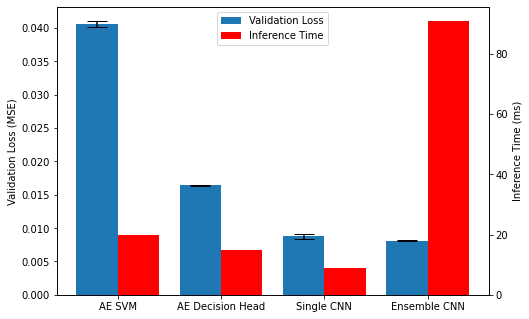

In [116]:
import matplotlib.pyplot as plt
from scipy.stats import t
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
models = ['AE SVM', 'AE Decision Head', 'Single CNN', 'Ensemble CNN']
scores = [svm_mean_loss, dh_mean_loss, cnn_mean_loss, ensemble_mean_loss]
print(scores)
vars = [svm_var_loss, dh_var_loss, cnn_var_loss, ensemble_var_loss]
lower_bounds = []
upper_bounds = []
talpha = t.ppf(0.025, 9)
for i in range(4):
    se = (vars[i]/10)**0.5
    lower_bounds.append(talpha*se)
    upper_bounds.append(-talpha*se)
yerr = np.array([lower_bounds, upper_bounds])
print(yerr.shape)
xloc = np.arange(len(models))
a = ax.bar(xloc-0.2, scores, yerr=np.abs(yerr),
           width=0.4, capsize=10, label='Validation loss')

plt.ylabel('Validation Loss (MSE)')
plt.xticks(xloc, models)
ax2 = ax.twinx()
ax2.set_ylabel('Inference Time (ms)')
b = ax2.bar(xloc+0.2, [20, 15, 9, 91], width=0.4,
            capsize=10, color='red', label='Inference Time')
ax.legend((a, b), ('Validation Loss', 'Inference Time'), loc='upper center')


(2,)


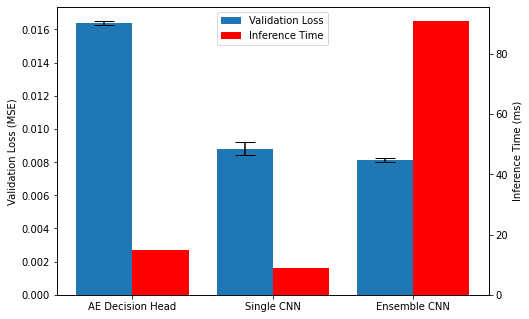

In [111]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
models = ['AE Decision Head', 'Single CNN', 'Ensemble CNN']
scores = [dh_mean_loss, cnn_mean_loss, ensemble_mean_loss]
vars = [dh_var_loss, cnn_var_loss, ensemble_var_loss]
lower_bounds = []
upper_bounds = []
talpha = t.ppf(0.025, 9)
for i in range(3):
    se = (vars[i]/10)**0.5
    lower_bounds.append(talpha*se)
    upper_bounds.append(-talpha*se)
yerr = np.array([lower_bounds, upper_bounds])
print(yerr[:, 0].shape)
xloc = np.arange(len(models))
a = ax.bar(xloc-0.2, scores, yerr=np.abs(yerr),
           width=0.4, capsize=10, label='Validation loss')

plt.ylabel('Validation Loss (MSE)')
plt.xticks(xloc, models)
ax2 = ax.twinx()
ax2.set_ylabel('Inference Time (ms)')
b = ax2.bar(xloc+0.2, [15, 9, 91], width=0.4, capsize=10,
            color='red', label='Inference Time',)
ax.legend((a, b), ('Validation Loss', 'Inference Time'), loc='upper center')


# T-test for ensemble vs single CNN

In [115]:
n = 10
sp2 = ((n-1)*vars[-2]+(n-1)*vars[-1])/(2*n-2)
tval = (scores[-2]-scores[-1])/((sp2*(1/n+1/n))**(1/2))
pval = 2*(1-t.cdf(np.abs(tval), 2*n-2))
print(pval)


0.00153087748357561
